In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
df = pd.read_csv('churn_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
state                     3333 non-null object
account length            3333 non-null int64
area code                 3333 non-null int64
phone number              3333 non-null object
international plan        3333 non-null object
voice mail plan           3333 non-null object
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64

In [4]:
df.churn.nunique()

2

In [5]:
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


**number of vmail messages, customer service calls may have outliers**

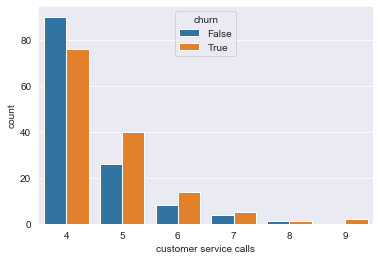

In [6]:
sns.countplot(x = 'customer service calls', data = df[df['customer service calls'] > 3], hue = 'churn')

**looks like there are some service problems**

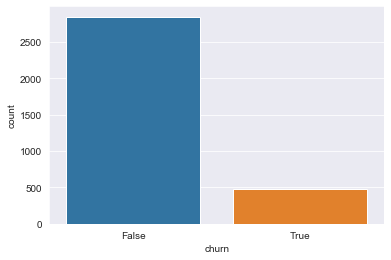

In [7]:
sns.countplot(x = "churn", data = df)

In [8]:
df['total night charge'].value_counts(normalize = True)

9.66     0.0045
9.45     0.0045
8.88     0.0042
8.47     0.0042
7.69     0.0039
          ...  
14.65    0.0003
6.46     0.0003
3.94     0.0003
15.74    0.0003
6.14     0.0003
Name: total night charge, Length: 933, dtype: float64

In [9]:
for col in df.columns:
    print("--------------------------------")
    print("Top 5 values in column", col)
    print(df[col].value_counts(normalize = True).head())
    print("--------------------------------")

--------------------------------
Top 5 values in column state
WV    0.031803
MN    0.025203
NY    0.024902
AL    0.024002
OR    0.023402
Name: state, dtype: float64
--------------------------------
--------------------------------
Top 5 values in column account length
105    0.012901
87     0.012601
93     0.012001
101    0.012001
90     0.011701
Name: account length, dtype: float64
--------------------------------
--------------------------------
Top 5 values in column area code
415    0.496550
510    0.252025
408    0.251425
Name: area code, dtype: float64
--------------------------------
--------------------------------
Top 5 values in column phone number
398-5970    0.0003
373-7037    0.0003
380-3186    0.0003
375-5547    0.0003
352-8202    0.0003
Name: phone number, dtype: float64
--------------------------------
--------------------------------
Top 5 values in column international plan
no     0.90309
yes    0.09691
Name: international plan, dtype: float64
------------------------

**investigate vmail messages a bit more**
**investigate international plan a little more**

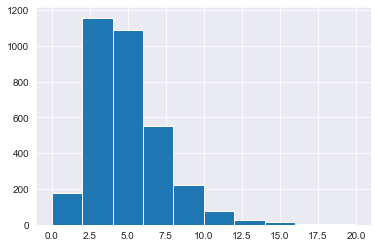

In [10]:
df['total intl calls'].hist()

In [11]:
df['international plan'] = (df['international plan'] == 'yes').astype(int)

In [12]:
df['voice mail plan'] = (df['voice mail plan'] == 'yes').astype(int)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
state                     3333 non-null object
account length            3333 non-null int64
area code                 3333 non-null int64
phone number              3333 non-null object
international plan        3333 non-null int64
voice mail plan           3333 non-null int64
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64
c

In [14]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [15]:
df.state.nunique()

51

In [17]:
df.state.value_counts(normalize = True)

WV    0.031803
MN    0.025203
NY    0.024902
AL    0.024002
OR    0.023402
OH    0.023402
WI    0.023402
VA    0.023102
WY    0.023102
CT    0.022202
MI    0.021902
VT    0.021902
ID    0.021902
UT    0.021602
TX    0.021602
IN    0.021302
MD    0.021002
KS    0.021002
NJ    0.020402
NC    0.020402
MT    0.020402
NV    0.019802
WA    0.019802
CO    0.019802
RI    0.019502
MA    0.019502
MS    0.019502
AZ    0.019202
MO    0.018902
FL    0.018902
NM    0.018602
ND    0.018602
ME    0.018602
DE    0.018302
NE    0.018302
OK    0.018302
SD    0.018002
SC    0.018002
KY    0.017702
IL    0.017402
NH    0.016802
AR    0.016502
DC    0.016202
GA    0.016202
HI    0.015902
TN    0.015902
AK    0.015602
LA    0.015302
PA    0.013501
IA    0.013201
CA    0.010201
Name: state, dtype: float64

In [18]:
df['area code'].nunique()

3

In [19]:
df['area code'].value_counts()

415    1655
510     840
408     838
Name: area code, dtype: int64

In [20]:
states_df = pd.read_csv("states.csv")

In [21]:
states_df.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [28]:
df = df.merge(states_df, left_on= 'state', right_on= 'State Code')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 25 columns):
state                     3333 non-null object
account length            3333 non-null int64
area code                 3333 non-null int64
phone number              3333 non-null object
international plan        3333 non-null int64
voice mail plan           3333 non-null int64
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64
c

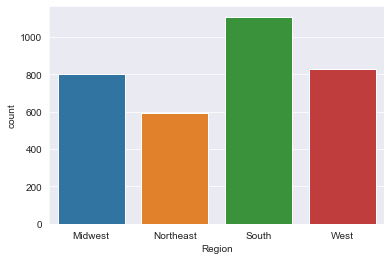

In [30]:
sns.countplot(x = "Region", data = df)

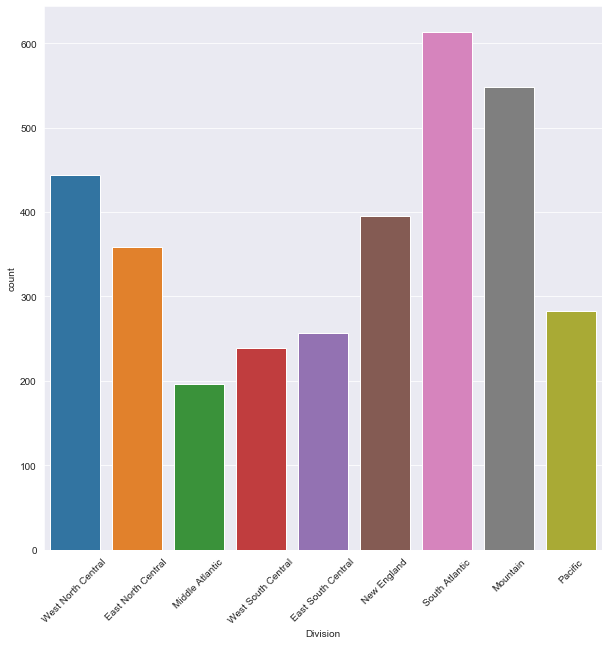

In [34]:
plt.figure(figsize = (10,10))
plt.xticks(rotation = 45)
sns.countplot(x = "Division", data = df)

In [35]:
df['phone number'].nunique()

3333

In [36]:
df_without_phone = df.drop('phone number', axis = 1)

In [38]:
df_without_phone.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 24 columns):
state                     3333 non-null object
account length            3333 non-null int64
area code                 3333 non-null int64
international plan        3333 non-null int64
voice mail plan           3333 non-null int64
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64
customer service calls    3333 non-null int64
ch

In [40]:
df_clean = df_without_phone.drop(['state', 'State', 'State Code', 'Region'], axis = 1)

In [41]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 20 columns):
account length            3333 non-null int64
area code                 3333 non-null int64
international plan        3333 non-null int64
voice mail plan           3333 non-null int64
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64
customer service calls    3333 non-null int64
churn                     3333 non-null bool
Divi

In [43]:
df_cleaned = pd.concat([df_clean.drop('Division', axis = 1), pd.get_dummies(df['Division'], prefix = 'Division')], axis = 1)

In [44]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 28 columns):
account length                 3333 non-null int64
area code                      3333 non-null int64
international plan             3333 non-null int64
voice mail plan                3333 non-null int64
number vmail messages          3333 non-null int64
total day minutes              3333 non-null float64
total day calls                3333 non-null int64
total day charge               3333 non-null float64
total eve minutes              3333 non-null float64
total eve calls                3333 non-null int64
total eve charge               3333 non-null float64
total night minutes            3333 non-null float64
total night calls              3333 non-null int64
total night charge             3333 non-null float64
total intl minutes             3333 non-null float64
total intl calls               3333 non-null int64
total intl charge              3333 non-null float64
customer s

In [46]:
df_cleaned['number vmail messages'].value_counts(normalize = True)

0     0.723372
31    0.018002
29    0.015902
28    0.015302
33    0.013801
27    0.013201
30    0.013201
24    0.012601
26    0.012301
32    0.012301
25    0.011101
23    0.010801
36    0.010201
35    0.009601
22    0.009601
39    0.009001
37    0.008701
34    0.008701
21    0.008401
38    0.007501
20    0.006601
19    0.005701
40    0.004800
42    0.004500
17    0.004200
41    0.003900
16    0.003900
43    0.002700
15    0.002700
18    0.002100
44    0.002100
14    0.002100
45    0.001800
12    0.001800
46    0.001200
13    0.001200
47    0.000900
8     0.000600
48    0.000600
50    0.000600
9     0.000600
11    0.000600
49    0.000300
10    0.000300
4     0.000300
51    0.000300
Name: number vmail messages, dtype: float64

In [48]:
df_cleaned['voice mail plan'].value_counts(normalize = True)

0    0.723372
1    0.276628
Name: voice mail plan, dtype: float64

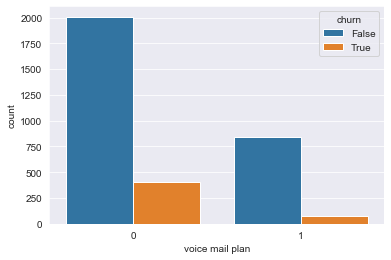

In [50]:
sns.countplot(x = 'voice mail plan', data = df_cleaned, hue = 'churn')

In [51]:
df_cleaned.to_csv("cleaned_churn_data.csv")